In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from PIL import Image
import numpy as np
import pandas as pd
import h5py
import tensorflow as tf
import matplotlib.pyplot as plt
import joblib

2025-05-04 06:46:13.695856: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746341173.706878    2970 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746341173.709822    2970 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


- External_images_1, 2에서 수집한 데이터를 이용하여 EfficientNetB1을 Pre-train을 시킵니다.

- AutoEncoder를 사용하고, 미세조정을 통한 EfficientNetB1을 이미지에 맞게 튜닝합니다.

- 이를 위해 Elucid에서 제공하는 데이터를 Train/Test를 구분하지 않고 이미지를 넣습니다.

- Spot에서는 위치하고 Slide 번호만 가져옵니다.

- 또한 메모리 효율화를 위해 0\~1 float32에서 0\~255 uint8로 변환하고, 학습 파이프라이에서 0~1 float32로 변환시켜 사용합니다.

In [3]:
def load_data(filename):
    """
    이미지를 불러옵니다.
    Parameters:
        filename: str
            h5 파일에서 데이터를 불러옵니다.
    Returns:
        np.ndarray, pd.DataFrame, np.ndarray, 
        train 이미지, train spot 정보, test 이미지, test spot 정보
    """
    images = list()
    spots = list()
    with h5py.File(filename, "r") as h5file:
        train_images = h5file["images/Train"]
        train_spots = h5file["spots/Train"]
    
        num_train_slides = len(train_images)
        # Train 이미지를 불러옵니다.
        # 하나의 텐서로 만들기 위해 이미지의 크기를 2000x2000으로 균일하게 만듭니다.
        for i, slide_name in enumerate(train_images.keys()):
            image = (np.array(train_images[slide_name]) * 255).astype('uint8')
            p1 = 2000 - image.shape[0]
            p2 = 2000 - image.shape[1]
            images.append(
                np.pad(image, [(0, p1), (0, p2), (0, 0)], 'edge')
            )
            spots.append(pd.DataFrame(np.array(train_spots[slide_name]))[['x', 'y']].assign(slide = i))
            if slide_name == 'S_2':
                spots[-1] = spots[-1].assign(
                    x = lambda x: x['x'] - 60,
                    y = lambda x: x['y'] - 60,
                )
        # Test 이미지를 불러옵니다.
        test_images = h5file["images/Test"]
        test_spots = h5file["spots/Test"]
        sample = 'S_7'
        image = (np.array(test_images[sample]) * 255).astype('uint8')
        p1 = 2000 - image.shape[0]
        p2 = 2000 - image.shape[1]
        images.append(np.pad(image, [(0, p1), (0, p2), (0, 0)], 'edge'))
        spots.append(pd.DataFrame(np.array(test_spots[sample]))[['x', 'y']].assign(slide = i + 1))
    return images, spots
images, spots = load_data("data/elucidata_ai_challenge_data.h5")

- Auto Encoder를 사용하여 EfficientNetB1을 Encoder에 포함시킵니다.

In [4]:
import glob
for i, (img_file, pkl_file) in enumerate(
    zip(glob.glob('data/*.jpg'), glob.glob('data/*.pkl'))
):
    image = np.array(
        Image.open(img_file).convert('RGB')
    )
    p1 = 2000 - image.shape[0]
    p2 = 2000 - image.shape[1]
    images.append(
        np.pad(image, [(0, p1), (0, p2), (0, 0)], 'edge')
    )
    spots.append(
        pd.read_pickle(pkl_file).rename(columns = lambda x: x.split('_')[1]).astype('int').assign(slide = len(spots))
    )
    print(img_file, pkl_file)

# EfficientNet의 형식으로 바꿉니다.
with tf.device('/CPU:0'):
    images = tf.constant(tf.keras.applications.efficientnet.preprocess_input(images))
df_spots = pd.concat(spots).reset_index(drop = True)

data/A1.jpg data/A1.pkl
data/A2.jpg data/A2.pkl
data/A3.jpg data/A3.pkl
data/A4.jpg data/A4.pkl
data/A5.jpg data/A5.pkl
data/A6.jpg data/A6.pkl
data/B1.jpg data/B1.pkl
data/B2.jpg data/B2.pkl
data/B3.jpg data/B3.pkl
data/B4.jpg data/B4.pkl
data/B5.jpg data/B5.pkl
data/B6.jpg data/B6.pkl
data/C1.jpg data/C1.pkl
data/C2.jpg data/C2.pkl
data/C3.jpg data/C3.pkl
data/C4.jpg data/C4.pkl
data/C5.jpg data/C5.pkl
data/C6.jpg data/C6.pkl
data/D1.jpg data/D1.pkl
data/D2.jpg data/D2.pkl
data/D3.jpg data/D3.pkl
data/D4.jpg data/D4.pkl
data/D5.jpg data/D5.pkl
data/D6.jpg data/D6.pkl
data/E1.jpg data/E1.pkl
data/E2.jpg data/E2.pkl
data/E3.jpg data/E3.pkl
data/F1.jpg data/F1.pkl
data/F2.jpg data/F2.pkl
data/F3.jpg data/F3.pkl
data/G1.jpg data/G1.pkl
data/G2.jpg data/G2.pkl
data/G3.jpg data/G3.pkl
data/GSM4284316.jpg data/GSM4284316.pkl
data/GSM4284317.jpg data/GSM4284317.pkl
data/GSM4284318.jpg data/GSM4284318.pkl
data/GSM4284319.jpg data/GSM4284319.pkl
data/GSM4284320.jpg data/GSM4284320.pkl
data/GSM

I0000 00:00:1746341178.218794    2970 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5520 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


- imagenet에 사전 학습한 가중치는 큰 의미가 없습니다. 사전 학습 모델을 사용하지 않습니다.

In [5]:
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.layers import Input, Conv2DTranspose, Reshape, Dense, Flatten
from tensorflow.keras.models import Model

# 입력 이미지 크기 (EfficientNetB1 최소 크기: 240x240)
input_shape = (240, 240, 3)
latent_dim = 128  # 잠재 벡터 크기

def assemble_encoder(enet, d):
    inputs = tf.keras.Input(shape = input_shape)
    x = enet(inputs)
    enet.trainable = True 
    x = d(x)
    return Model(inputs=inputs, outputs=x, name='encoder')

# 인코더: EfficientNetB1 백본
def build_encoder():
    enet = tf.keras.applications.EfficientNetB1(
        include_top = False, 
        #weights = 'imagenet',
        input_shape = input_shape,
        pooling = 'avg'
    )
    d = Dense(latent_dim, activation='relu')
    return assemble_encoder(enet, d), (enet, d)

# 디코더: Latent vector → 이미지 복원
def build_decoder():
    decoder_input = Input(shape=(latent_dim,))
    
    x = Dense(15*15*64, activation='relu')(decoder_input)
    x = Reshape((15, 15, 64))(x)

    x = Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')(x)  # 30x30
    x = Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')(x)  # 60x60
    x = Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu')(x)  # 120x120
    x = Conv2DTranspose(16, 3, strides=2, padding='same', activation='relu')(x)  # 240x240
    
    decoded = Conv2DTranspose(3, 3, activation='sigmoid', padding='same')(x)
    return Model(inputs=decoder_input, outputs=decoded, name='decoder')

def make_img_proc_info(df, img_width, img_height):
    return df.assign(
        left = lambda x: x['x'] - img_width // 2,
        right = lambda x: x['x'] + img_width // 2,
        top = lambda x: x['y'] - img_height // 2,
        bottom = lambda x: x['y'] + img_height // 2,
        lpad = lambda x: -(x['left'].where(x['left'] < 0, 0)),
        rpad = lambda x: -(2000 - x['right']).where(x['right'] > 2000, 0),
        tpad = lambda x: -(x['top'].where(x['top'] < 0, 0)),
        bpad = lambda x: -(2000 - x['bottom']).where(x['bottom'] > 2000, 0)
    ).assign(
        left = lambda x: x['left'].clip(0, 2000),
        right = lambda x: x['right'].clip(0, 2000),
        top = lambda x: x['top'].clip(0, 2000),
        bottom = lambda x: x['bottom'].clip(0, 2000),
    )
df_spots = make_img_proc_info(df_spots, input_shape[0], input_shape[1])

In [6]:
df_spots

,x,y,slide,left,right,top,bottom,lpad,rpad,tpad,bpad
0,1554,1297,0,1434,1674,1177,1417,0,0,0,0
1,462,1502,0,342,582,1382,1622,0,0,0,0
2,1488,1548,0,1368,1608,1428,1668,0,0,0,0
3,1725,1182,0,1605,1845,1062,1302,0,0,0,0
4,581,1113,0,461,701,993,1233,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
32776,814,1918,54,694,934,1798,2000,0,0,0,38
32777,644,1920,54,524,764,1800,2000,0,0,0,40
32778,524,1920,54,404,644,1800,2000,0,0,0,40
32779,758,1920,54,638,878,1800,2000,0,0,0,40


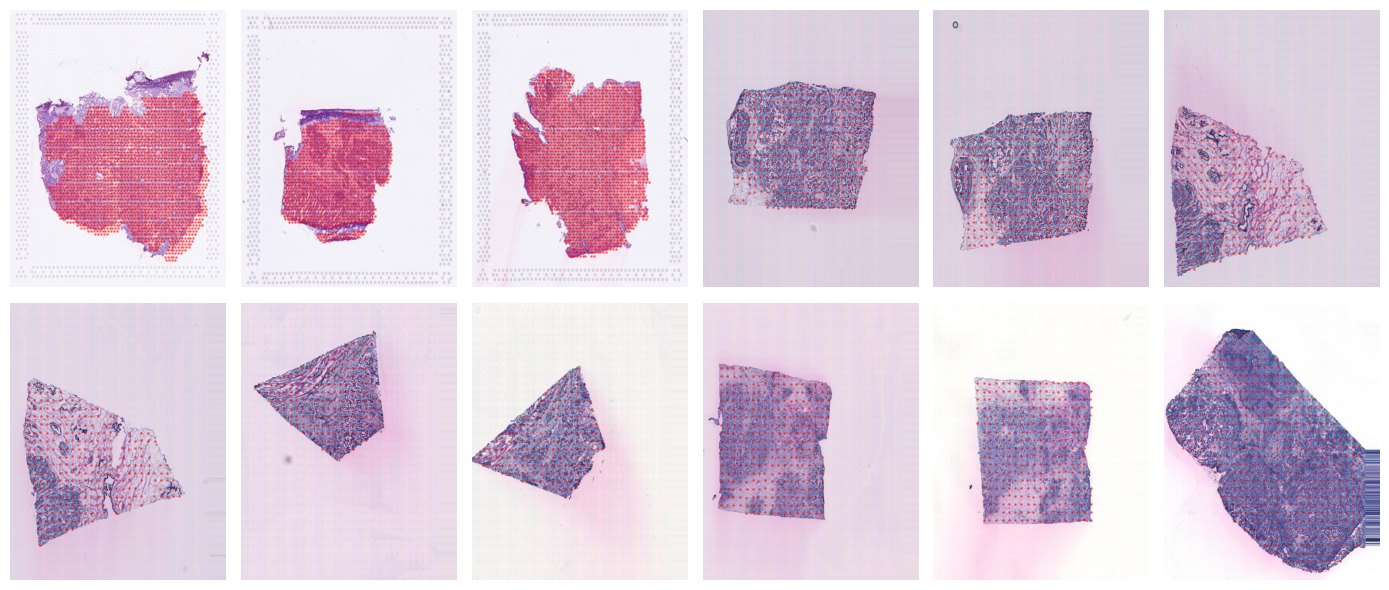

In [7]:
fig, ax = plt.subplots(2, 6, figsize=(14, 6))
ax = ax.flatten()
for i, ax in zip(range(0, len(images), 3), ax):
    image = images[i]
    x, y = df_spots.loc[df_spots['slide'] == i, "x"], df_spots.loc[df_spots['slide'] == i, "y"]
    
    ax.imshow(image, aspect="auto")
    ax.scatter(x, y, color="red", s=1, alpha=0.4)  # Overlay spot locations
    ax.axis('off')

plt.tight_layout()
plt.show()
del image

In [7]:
def create_tf_ds(df):
    df_s = df.sample(frac = 1.0)
    return tf.data.Dataset.from_tensor_slices({
        i: df_s[i] for i in ['left', 'right', 'top', 'bottom', 'slide', 'lpad', 'rpad', 'tpad', 'bpad']
    })

def proc_images(X, images):
    return tf.cast(tf.pad(
        images[X['slide'], X['left']:X['right'], X['top']:X['bottom'], :], 
        paddings = [(X['lpad'], X['rpad']), (X['tpad'], X['bpad']), (0, 0)],
        constant_values=255
    ), tf.float32) / 255.0

augmentation_layers = [
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.5),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
]

def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x

In [8]:
# 전체 오토인코더 모델
encoder, objs = build_encoder()
decoder = build_decoder()

input_img = Input(shape=input_shape)
latent = encoder(input_img)
reconstructed = decoder(latent)

autoencoder = Model(inputs=input_img, outputs=reconstructed, name='eb1_ae')
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.001,
    decay_steps=24000,
    alpha=0.1
)
# 컴파일
autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = lr_schedule), 
    loss=tf.keras.losses.MeanSquaredError(),
    metrics = [tf.keras.metrics.RootMeanSquaredError()]
)

# 요약 확인
autoencoder.summary()

Model: "eb1_ae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 240, 240, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder (Functional)                 │ (None, 128)                 │       6,739,207 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Functional)                 │ (None, 240, 240, 3)         │       1,954,979 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,694,186 (33.17 MB)

 Trainable params: 8,632,131 (32.93 MB)

 Non-trainable params: 62,055 (242.41 KB)

In [9]:
from tensorflow.keras.callbacks import Callback
from tqdm import tqdm

class TQDMProgressBar(Callback):
    def on_train_begin(self, logs=None):
        self.epochs = self.params['epochs']
        self.tqdm_bar = tqdm(total=self.epochs, desc="Epochs", unit="epoch")

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        log_str = f"loss={logs.get('loss'):.4f}"
        if 'val_loss' in logs:
            log_str += f", val_loss={logs['val_loss']:.4f}"
        self.tqdm_bar.set_postfix_str(log_str)
        self.tqdm_bar.update(1)

    def on_train_end(self, logs=None):
        self.tqdm_bar.close()

In [10]:
batch_size = 32
ds_train = create_tf_ds(
    df_spots.pipe(
        lambda x: pd.concat([
            x, x.sample(n = batch_size - (len(x) % batch_size))
        ])
    )
).shuffle(30000).map(
    lambda X: proc_images(X, images)
).map(
    lambda X: data_augmentation(X)
).batch(batch_size).prefetch(tf.data.AUTOTUNE).cache().map(
    lambda X: (X, X)
)

In [11]:
hist = autoencoder.fit(ds_train, epochs=18)#, verbose = 0, callbacks = [TQDMProgressBar()])
joblib.dump((objs[0].get_weights(), objs[1].get_weights()), 'model/ae_encoder_b1_obj.joblib')
joblib.dump(decoder.get_weights(), 'model/ae_decoder_b1.joblib')

Epoch 1/15


I0000 00:00:1746338274.944318    2295 service.cc:148] XLA service 0x7f3fe0006fb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746338274.944350    2295 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
I0000 00:00:1746338278.780105    2295 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1746338292.870261    2295 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746338293.044927    2295 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746338301.634920    2295 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1

 773/1025 ━━━━━━━━━━━━━━━━━━━━ 1:26 341ms/step - loss: 0.0285 - root_mean_squared_error: 0.1648

2025-05-04 06:03:06.710834: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:1253] failed to alloc 17179869184 bytes on host: RESOURCE_EXHAUSTED: : CUDA_ERROR_OUT_OF_MEMORY: out of memory
W0000 00:00:1746338586.710887    2324 device_host_allocator.h:61] could not allocate pinned host memory of size: 17179869184


1025/1025 ━━━━━━━━━━━━━━━━━━━━ 445s 350ms/step - loss: 0.0260 - root_mean_squared_error: 0.1575
Epoch 2/15
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 151s 148ms/step - loss: 0.0141 - root_mean_squared_error: 0.1186
Epoch 3/15
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 152s 149ms/step - loss: 0.0129 - root_mean_squared_error: 0.1138
Epoch 4/15
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 152s 148ms/step - loss: 0.0123 - root_mean_squared_error: 0.1111
Epoch 5/15
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 152s 148ms/step - loss: 0.0120 - root_mean_squared_error: 0.1095
Epoch 6/15
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 152s 148ms/step - loss: 0.0117 - root_mean_squared_error: 0.1084
Epoch 7/15
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 151s 147ms/step - loss: 0.0115 - root_mean_squared_error: 0.1072
Epoch 8/15
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 152s 148ms/step - loss: 0.0111 - root_mean_squared_error: 0.1054
Epoch 9/15
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 152s 148ms/step - loss: 0.0109 - root_mean_squared_error: 0.1044
Epoch 10/15
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 152s 

['model/ae_decoder.joblib']

In [12]:
objs_ = joblib.load('model/ae_encoder_b1_obj.joblib')
encoder, objs = build_encoder()
objs[0].set_weights(objs_[0])
objs[1].set_weights(objs_[1])
del objs_
decoder_ = joblib.load('model/ae_decoder_b1.joblib')
decoder = build_decoder()
decoder.set_weights(decoder_)
del decoder_
input_img = Input(shape=input_shape)
latent = encoder(input_img)
reconstructed = decoder(latent)

autoencoder = Model(inputs=input_img, outputs=reconstructed, name='eb1_ae')

In [13]:
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.00001,
    decay_steps=5000,
    alpha=0.1
)
# 컴파일
autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = lr_schedule), 
    loss=tf.keras.losses.MeanSquaredError(),
    metrics = [tf.keras.metrics.RootMeanSquaredError()]
)

hist = autoencoder.fit(ds_train, epochs=5)#, verbose = 0, callbacks = [TQDMProgressBar()])
joblib.dump((objs[0].get_weights(), objs[1].get_weights()), 'model/ae_encoder_b1_obj.joblib')
joblib.dump(decoder.get_weights(), 'model/ae_decoder_b1.joblib')

Epoch 1/5


E0000 00:00:1746342016.340667    3019 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746342016.520615    3019 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746342016.702445    3019 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746342025.400943    3019 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746342025.160682    3019 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

1025/1025 ━━━━━━━━━━━━━━━━━━━━ 231s 149ms/step - loss: 0.0102 - root_mean_squared_error: 0.1011
Epoch 2/5
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 156s 153ms/step - loss: 0.0102 - root_mean_squared_error: 0.1009
Epoch 3/5
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 156s 153ms/step - loss: 0.0102 - root_mean_squared_error: 0.1008
Epoch 4/5
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 157s 153ms/step - loss: 0.0102 - root_mean_squared_error: 0.1008
Epoch 5/5
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 156s 152ms/step - loss: 0.0102 - root_mean_squared_error: 0.1008


In [16]:
img_input = None
for i, _ in ds_train.take(1):
    img_input = i
output = autoencoder(img_input)

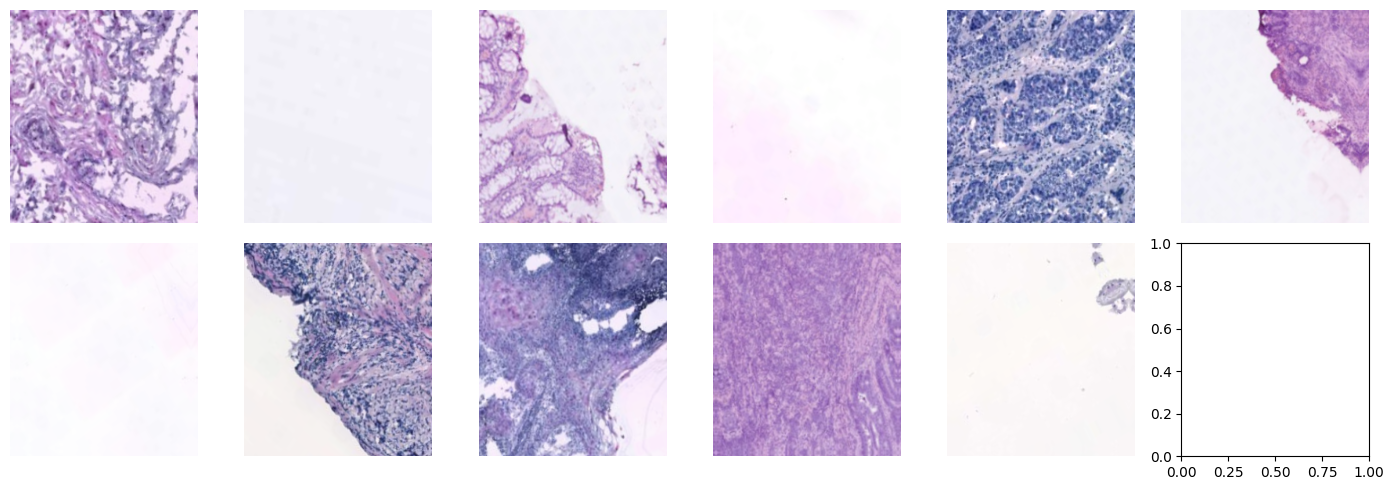

In [17]:
fig, ax = plt.subplots(2, 6, figsize=(14, 5))
ax = ax.flatten()
for i, ax in zip(range(0, 32, 3), ax):
    ax.imshow(np.clip(img_input[i], 0, 1), aspect="auto")
    ax.axis('off')

plt.tight_layout()
plt.show()

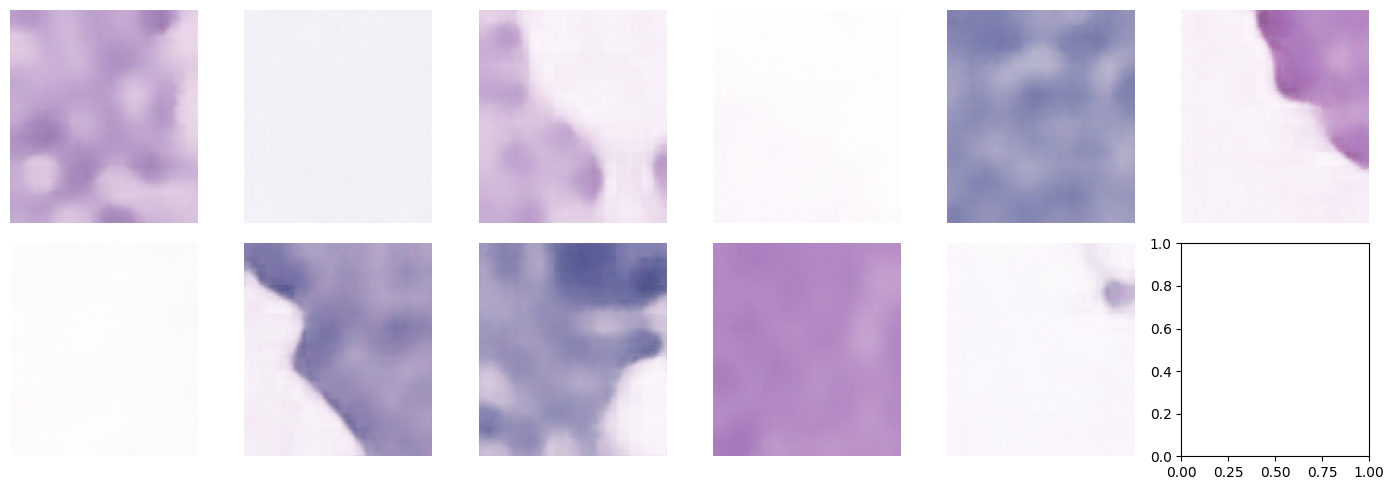

In [18]:
fig, ax = plt.subplots(2, 6, figsize=(14, 5))
ax = ax.flatten()
for i, ax in zip(range(0, 32, 3), ax):
    ax.imshow(output[i], aspect="auto")
    ax.axis('off')

plt.tight_layout()
plt.show()